# Background

# Imports

In [163]:
import os
import numpy as np
import pandas as pd
import lmfit as lm
from dateutil import parser
import pickle as pkl
from scipy.interpolate import interp1d

from plotly import graph_objects as go
from plotly.offline import plot, iplot
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

from plotting import config_plots, ticks_in, get_label
config_plots()

In [2]:
from process_funcs import load_data, get_probe_IDs, Hall_probe_basic_calcs, match_temp_scan_dfs, interp_temp_col

# Functions

- Some or all of these should go into scripts / packages later so that they are easily used (either in a driving notebook or script)

In [27]:
class PoleToPole(object):
    def __init__(self, ddir_run_info, ddir_raw, ddir_proc, t0=None, tf=None):
        # filter to e.g. recent files using t0
        #self.probe_ID = probe_ID
        self.ddir_run_info = ddir_run_info
        self.ddir_raw = ddir_raw
        self.ddir_proc = ddir_proc
        #self.BEst = BEst # B estimation (from magnet ramp measurements)
        #self.BLocCorr = BLocCorr # NMR vs. Hall location correction (from pole-to-pole measurements)
        # find files of interest
        self.all_run_files = [ddir_run_info+f for f in os.listdir(ddir_run_info)]
        self.scan_files = [f for f in self.all_run_files if 'pole_to_pole_runs' in f]
        self.slowscan_files = [f for f in self.all_run_files if 'slowscan' in f and 'pole_to_pole' in f]
        # load all files from the csv lists
        df_scans_list = []
        df_slowscans_list = []
        for files, df_list in zip([self.scan_files, self.slowscan_files], [df_scans_list, df_slowscans_list]):
            for f in files:
                df_ = pd.read_csv(f)
                df_list.append(df_)
        self.df_scans_list = df_scans_list
        self.df_slowscans_list = df_slowscans_list
        self.df_scans = pd.concat(self.df_scans_list)
        self.df_slowscans = pd.concat(self.df_slowscans_list)
        # calculate time range of scans, and filter to only the needed slow scans
        self.dates_scans = np.array([parser.parse(f.split('.txt')[0]) for f in self.df_scans.filename]) 
        if tf is None:
            self.tf = np.max(self.dates_scans)
        else:
            self.tf = tf
        if t0 is None:
            self.t0 = np.min(self.dates_scans)
            self.df_scans_filt = self.df_scans.copy()
        else:
            self.t0 = t0
            self.df_scans_filt = self.filter_scan_list(self.df_scans)
        self.dates_slowscans = np.array([parser.parse(f.split('slow.txt')[0]) for f in self.df_slowscans.filename])
        self.df_slowscans_filt = self.filter_scan_list(self.df_slowscans, is_slow=True) # only include slow scan files that encapsulate the scans

    def filter_scan_list(self, df_init, is_slow=False):
        if is_slow:
            split_str = 'slow.txt'
            i0_off = 0
        else:
            split_str = '.txt'
            i0_off = +1
        dates = np.array([parser.parse(f.split(split_str)[0]) for f in df_init.filename]) 
        # calculate index of first and last file to use
        t0_delta = np.array([(dt).total_seconds() for dt in dates - self.t0])
        i_0 = np.arange(len(t0_delta))[t0_delta < 0.][-1] + i0_off
        tf_delta = np.array([(dt).total_seconds() for dt in dates - self.tf])
        is_f = np.arange(len(tf_delta))[tf_delta > 0.]
        if len(is_f) > 0:
            i_f = is_f[0] + 1
            if i_f > len(tf_delta)-1:
                i_f = None
        else:
            i_f = None # assume last slow scan available will encompass the scans
        df = df_init.iloc[i_0:i_f].copy()
        df.reset_index(drop=True, inplace=True)
        return df

    def process_data(self):
        ddir = self.ddir_raw
        df = [] # scan data
        df_temps = [] # slow controls --> these will be interpolated to the scan data points
        # columns to add in each file type
        cols_scan = [c for c in self.df_scans_filt.columns if c != 'filename']
        cols_slowscan = [c for c in self.df_slowscans_filt.columns if c != 'filename']
        # slow scans
        for row in self.df_slowscans_filt.itertuples():
            f = row.filename
            df_ = load_data(ddir+f)
            # add relevant run columns
            for c in cols_slowscan:
                df_.loc[:, c] = eval(f'row.{c}')
            df_temps.append(df_)
        # concatenate dataframes
        # self.df = pd.concat(df)
        self.df_temps = pd.concat(df_temps)
        t0 = self.df_temps.index.iloc[0]
        for df in [self.df_temps]:
            df.loc[:, 'seconds_delta'] = (df.index - t0).total_seconds()
            df.loc[:, 'hours_delta'] = df.loc[:, 'seconds_delta']/60**2
            df.loc[:, 'days_delta'] = df.loc[:, 'seconds_delta']/(24*60**2)
        # load the scan data, skipping the first row (it is collected when you click "data saving" and
        # does not correspond to the scan
        for row in self.df_scans_filt.itertuples():
            f = row.filename
            nmr = row.nmr
            if nmr == 'low':
                low_NMR=True
            else:
                low_NMR=False
            df_ = load_data(ddir+f, low_NMR=low_NMR).iloc[1:] # from process_funcs
            # add relevant run columns
            for c in cols_scan:
                df_.loc[:, c] = eval(f'row.{c}')
            df.append(df_)
        # after concatenations, need to reevaluate time
        # use t0 we have defined for consistent timing between the two
        for df in [self.df, self.df_temps]:
            df.loc[:, 'seconds_delta'] = (df.index - self.t0).total_seconds()
            df.loc[:, 'hours_delta'] = df.loc[:, 'seconds_delta']/60**2
            df.loc[:, 'days_delta'] = df.loc[:, 'seconds_delta']/(24*60**2)
        # apply calculations to Hall probe measurements (|B|, angles, etc.)
        #self.df = Hall_probe_basic_calcs(self.df, [self.probe_ID])
        # interpolate slow scan data to Hall probe
        self.interp_slow_to_scans()
        # query appropriate time range for slow scan
        ###self.df_temps_match = match_temp_scan_dfs(self.df_temps, self.df)

    def interp_slow_to_scans(self):
        #cols_not_interp = ['Time', 'NaN (NWC-R)', 'NaN (NWC-S)', 'NMR [FFT]', 'seconds_delta', 'hours_delta', 'days_delta', 'has_nmr']
        cols_not_interp = ['NMR [T]', 'Time', 'NaN (NWC-R)', 'NaN (NWC-S)', 'NMR [FFT]', 'seconds_delta', 'hours_delta', 'days_delta', 'has_nmr']
        cols_copy_direct = ['has_nmr']
        for col in self.df_temps.columns:
            if col not in cols_not_interp:
                self.df = interp_temp_col(self.df_temps, self.df, col=col, kind='linear')
            elif col in cols_copy_direct:
                self.df = interp_temp_col(self.df_temps, self.df, col=col, kind='nearest')

    # FIXME! Add quality checks
    ## DATA QUALITY CHECKS HERE
    #######
    def check_data_qual(self):
        self.df_clean = self.df.copy()
    #######
'''
    # use pole-to-pole and magnet ramp data to correct for:
    # 1. diff in Hall probe / NMR location
    # 2. low field settings without NMR meas
    # To Do: add weighting based on whether we have NMR or estimate |B| from prior measurements
    def get_B_ref(self):
        self.df_clean.eval('B = `NMR [T]`', inplace=True) # start with NMR
        map_est = np.isclose(self.df_clean.has_nmr, 0.) # these point need to be estimated
        # regression model has already corrected for yoke temperature (thermal expansion)
        # FIXME! Should apply temperature correction (expect <1e-4 effect)
        # --> magnet ramp with high field probe shows effect almost goes to zero (<0.1e-4 T / deg C) at I=125 A
        #     and we need estimates for I <= 105 A
        # assume completely symmetric in current
        I = self.df_clean['Magnet Current [A]'].abs().values
        ###T_Yoke = self.df['Yoke (center magnet)'].values
        self.df_clean.loc[map_est, 'B'] = self.BEst.B(I)
        # apply pole-to-pole
        self.df_clean.eval('B_corr = B', inplace=True)
        if self.BEst.needs_loc_corr: # to everything
            self.df_clean.loc[:, 'B_corr'] = self.BLocCorr.B_corr(self.df_clean.loc[:, 'B'].values)
        else: # only to NMR measurements
            self.df_clean.loc[~map_est, 'B_corr'] = self.BLocCorr.B_corr(self.df_clean.loc[~map_est, 'B'].values)
'''
pass;

In [54]:
# second attempt -- interpolate slow to scans first. also label runs in slow scans\

In [99]:
class PoleToPole(object):
    def __init__(self, ddir_run_info, ddir_raw, ddir_proc, t0=None, tf=None):
        # filter to e.g. recent files using t0
        #self.probe_ID = probe_ID
        self.ddir_run_info = ddir_run_info
        self.ddir_raw = ddir_raw
        self.ddir_proc = ddir_proc
        #self.BEst = BEst # B estimation (from magnet ramp measurements)
        #self.BLocCorr = BLocCorr # NMR vs. Hall location correction (from pole-to-pole measurements)
        # find files of interest
        self.all_run_files = [ddir_run_info+f for f in os.listdir(ddir_run_info)]
        self.scan_files = [f for f in self.all_run_files if 'pole_to_pole_runs' in f]
        self.slowscan_files = [f for f in self.all_run_files if 'slowscan' in f and 'pole_to_pole' in f]
        # load all files from the csv lists
        df_scans_list = []
        df_slowscans_list = []
        for files, df_list in zip([self.scan_files, self.slowscan_files], [df_scans_list, df_slowscans_list]):
            for f in files:
                df_ = pd.read_csv(f)
                df_list.append(df_)
        self.df_scans_list = df_scans_list
        self.df_slowscans_list = df_slowscans_list
        self.df_scans = pd.concat(self.df_scans_list)
        self.df_slowscans = pd.concat(self.df_slowscans_list)
        # calculate time range of scans, and filter to only the needed slow scans
        self.dates_scans = np.array([parser.parse(f.split('.txt')[0]) for f in self.df_scans.filename]) 
        if tf is None:
            self.tf = np.max(self.dates_scans)
        else:
            self.tf = tf
        if t0 is None:
            self.t0 = np.min(self.dates_scans)
            self.df_scans_filt = self.df_scans.copy()
        else:
            self.t0 = t0
            self.df_scans_filt = self.filter_scan_list(self.df_scans)
        self.dates_slowscans = np.array([parser.parse(f.split('slow.txt')[0]) for f in self.df_slowscans.filename])
        self.df_slowscans_filt = self.filter_scan_list(self.df_slowscans, is_slow=True) # only include slow scan files that encapsulate the scans

    def filter_scan_list(self, df_init, is_slow=False):
        if is_slow:
            split_str = 'slow.txt'
            i0_off = 0
        else:
            split_str = '.txt'
            i0_off = +1
        dates = np.array([parser.parse(f.split(split_str)[0]) for f in df_init.filename]) 
        # calculate index of first and last file to use
        t0_delta = np.array([(dt).total_seconds() for dt in dates - self.t0])
        i_0 = np.arange(len(t0_delta))[t0_delta < 0.][-1] + i0_off
        tf_delta = np.array([(dt).total_seconds() for dt in dates - self.tf])
        is_f = np.arange(len(tf_delta))[tf_delta > 0.]
        if len(is_f) > 0:
            i_f = is_f[0] + 1
            if i_f > len(tf_delta)-1:
                i_f = None
        else:
            i_f = None # assume last slow scan available will encompass the scans
        df = df_init.iloc[i_0:i_f].copy()
        df.reset_index(drop=True, inplace=True)
        return df

    def process_data(self):
        ddir = self.ddir_raw
        #df = [] # scan data
        df_temps = [] # slow controls --> these will be interpolated to the scan data points
        # columns to add in each file type
        cols_scan = [c for c in self.df_scans_filt.columns if c != 'filename']
        cols_slowscan = [c for c in self.df_slowscans_filt.columns if c != 'filename']
        # slow scans
        self.slow_meta_dict = {}
        for i, row in enumerate(self.df_slowscans_filt.itertuples()):
            f = row.filename
            df_ = load_data(ddir+f)
            if i == 0:
                t0 = df_.index[0]
                self.t0_ref = t0
            # time (using slow controls start time)
            df_.loc[:, 'seconds_delta'] = (df_.index - t0).total_seconds()
            df_.loc[:, 'hours_delta'] = df_.loc[:, 'seconds_delta']/60**2
            df_.loc[:, 'days_delta'] = df_.loc[:, 'seconds_delta']/(24*60**2)
            # add relevant run columns
            for c in cols_slowscan:
                df_.loc[:, c] = eval(f'row.{c}')
            # add run index
            df_.loc[:, 'run_index_slow'] = i
            df_temps.append(df_)
            # update meta dict
            # FIXME! Do I want the actual times, or just seconds_delta?
            #t_i = df_.index.iloc[0]
            #t_f = df_.index.iloc[-1]
            t_i = df_.seconds_delta.iloc[0]
            t_f = df_.seconds_delta.iloc[-1]
            self.slow_meta_dict[i] = [t_i, t_f]
        # concatenate dataframes
        # self.df = pd.concat(df)
        self.df_temps = pd.concat(df_temps)
        #t0 = self.df_temps.index.iloc[0]
        #for df in [self.df_temps]:
        #    df.loc[:, 'seconds_delta'] = (df.index - t0).total_seconds()
        #    df.loc[:, 'hours_delta'] = df.loc[:, 'seconds_delta']/60**2
        #    df.loc[:, 'days_delta'] = df.loc[:, 'seconds_delta']/(24*60**2)
        # load the scan data, skipping the first row (it is collected when you click "data saving" and
        # does not correspond to the scan
        df = [] # scan data
        for row in self.df_scans_filt.itertuples():
            f = row.filename
            nmr = row.nmr
            if nmr == 'low':
                low_NMR=True
            else:
                low_NMR=False
            df_ = load_data(ddir+f, low_NMR=low_NMR).iloc[1:] # from process_funcs
            # add relevant run columns
            for c in cols_scan:
                df_.loc[:, c] = eval(f'row.{c}')
            # time (using slow controls start time)
            df_.loc[:, 'seconds_delta'] = (df_.index - t0).total_seconds()
            df_.loc[:, 'hours_delta'] = df_.loc[:, 'seconds_delta']/60**2
            df_.loc[:, 'days_delta'] = df_.loc[:, 'seconds_delta']/(24*60**2)
            # query correct slow controls run and interpolate
            best_i = 0
            best_frac = 0.
            t_i_scan = df_.seconds_delta.iloc[0]
            t_f_scan = df_.seconds_delta.iloc[-1]
            for i, range_slow in self.slow_meta_dict.items():
                frac_in = self.frac_scan_in_slow([t_i_scan, t_f_scan], range_slow)
                if frac_in > best_frac:
                    best_i = i
                    best_frac = frac_in
                if best_frac > 0.99:
                    break          
            df_s = self.df_temps.query(f'run_index_slow == {best_i}').query(f'({t_i_scan} <= seconds_delta <= {t_f_scan})')
            df_ = self.interp_slow_to_scans(df_, df_s)
            df.append(df_)
        # after concatenations, need to reevaluate time
        # use t0 we have defined for consistent timing between the two
        #for df in [self.df, self.df_temps]:
        #    df.loc[:, 'seconds_delta'] = (df.index - self.t0).total_seconds()
        #    df.loc[:, 'hours_delta'] = df.loc[:, 'seconds_delta']/60**2
        #    df.loc[:, 'days_delta'] = df.loc[:, 'seconds_delta']/(24*60**2)
        self.df = pd.concat(df)
        # apply calculations to Hall probe measurements (|B|, angles, etc.)
        #self.df = Hall_probe_basic_calcs(self.df, [self.probe_ID])
        # interpolate slow scan data to Hall probe
        #self.interp_slow_to_scans()
        # query appropriate time range for slow scan
        ###self.df_temps_match = match_temp_scan_dfs(self.df_temps, self.df)

    def frac_scan_in_slow(self, range_scan, range_slow):
        start_overlap = max(range_scan[0], range_slow[0])
        end_overlap = min(range_scan[1], range_slow[1])
        dt_overlap = end_overlap - start_overlap
        if dt_overlap < 0:
            frac_in = 0.0
        else:
            frac_in = dt_overlap / (range_scan[1] - range_scan[0])
        return frac_in
    
    def interp_slow_to_scans(self, df, df_temps):
        #cols_not_interp = ['Time', 'NaN (NWC-R)', 'NaN (NWC-S)', 'NMR [FFT]', 'seconds_delta', 'hours_delta', 'days_delta', 'has_nmr']
        cols_not_interp = ['NMR [T]', 'Time', 'NaN (NWC-R)', 'NaN (NWC-S)', 'NMR [FFT]',
                           'seconds_delta', 'hours_delta', 'days_delta', 'has_nmr']
        for c in df_temps.columns:
            if 'Zaber' in c:
                cols_not_interp.append(c)
        cols_copy_direct = ['has_nmr']
        for col in df_temps.columns:
            if col not in cols_not_interp:
                df = interp_temp_col(df_temps, df, col=col, kind='linear')
            elif col in cols_copy_direct:
                df = interp_temp_col(df_temps, df, col=col, kind='nearest')
        return df

    # FIXME! Add quality checks
    ## DATA QUALITY CHECKS HERE
    #######
    def check_data_qual(self):
        self.df_clean = self.df.copy()
    #######

    # def get_run(

'''
    # use pole-to-pole and magnet ramp data to correct for:
    # 1. diff in Hall probe / NMR location
    # 2. low field settings without NMR meas
    # To Do: add weighting based on whether we have NMR or estimate |B| from prior measurements
    def get_B_ref(self):
        self.df_clean.eval('B = `NMR [T]`', inplace=True) # start with NMR
        map_est = np.isclose(self.df_clean.has_nmr, 0.) # these point need to be estimated
        # regression model has already corrected for yoke temperature (thermal expansion)
        # FIXME! Should apply temperature correction (expect <1e-4 effect)
        # --> magnet ramp with high field probe shows effect almost goes to zero (<0.1e-4 T / deg C) at I=125 A
        #     and we need estimates for I <= 105 A
        # assume completely symmetric in current
        I = self.df_clean['Magnet Current [A]'].abs().values
        ###T_Yoke = self.df['Yoke (center magnet)'].values
        self.df_clean.loc[map_est, 'B'] = self.BEst.B(I)
        # apply pole-to-pole
        self.df_clean.eval('B_corr = B', inplace=True)
        if self.BEst.needs_loc_corr: # to everything
            self.df_clean.loc[:, 'B_corr'] = self.BLocCorr.B_corr(self.df_clean.loc[:, 'B'].values)
        else: # only to NMR measurements
            self.df_clean.loc[~map_est, 'B_corr'] = self.BLocCorr.B_corr(self.df_clean.loc[~map_est, 'B'].values)
'''
pass;

# Main

In [113]:
ddir_run_info = 'run_info/'
ddir_raw = '/home/ckampa/Dropbox/LogFiles/'
ddir_proc = '/home/ckampa/data/hallprobecalib_extras/datafiles/Thesis_Calibration/'

In [114]:
myPTP = PoleToPole(ddir_run_info=ddir_run_info,
                   ddir_raw=ddir_raw,
                   ddir_proc=ddir_proc,
                   t0=None, # no filter
                   # t0=parser.parse('2025-05-20 00:00'), # only process recent files
                   tf=None,
                  )

In [115]:
# initial process (concatenation)
myPTP.process_data()

In [116]:
myPTP.df

,Time,Magnet Current [A],Magnet Voltage [V],NMR [T],NMR [FFT],Zaber_Pattern_X,Zaber_Pattern_Y,Zaber_Pattern_Z,Zaber_Meas_Encoder_X,Zaber_Meas_Micron_X,...,Tripplite HVAC exhaust,EvapCoil (NWC),Barrel/Reservoir (FNAL),Return PS (FNAL),Return Magnet (NWC-R),Chiller Exhaust (NW),Supply Magnet (NWC-S),Supply PS (FNAL),has_nmr,run_index_slow
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-05-26 10:07:21,5/26/2022 10:07:21 AM,128.036001,14.185726,0.735854,0.0,426758.0,426431.0,1718667.0,426758.0,166702.34375,...,37.066756,22.866568,22.345502,32.657216,4.380914,31.628053,2.681633,23.195955,0.0,0.0
2022-05-26 10:07:57,5/26/2022 10:07:57 AM,128.036015,14.185722,0.735850,0.0,431878.0,426431.0,1718667.0,431878.0,168702.34375,...,37.700896,22.863773,22.348315,32.658373,4.369273,31.400177,2.698745,23.196648,0.0,0.0
2022-05-26 10:08:33,5/26/2022 10:08:33 AM,128.036029,14.185717,0.735843,0.0,436998.0,426431.0,1718667.0,436998.0,170702.34375,...,38.335035,22.860978,22.351129,32.659530,4.357633,31.172302,2.715857,23.197342,0.0,0.0
2022-05-26 10:09:09,5/26/2022 10:09:09 AM,128.036042,14.185712,0.735837,0.0,442118.0,426431.0,1718667.0,442118.0,172702.34375,...,38.969174,22.858184,22.353942,32.660686,4.345992,30.944427,2.732969,23.198035,0.0,0.0
2022-05-26 10:09:45,5/26/2022 10:09:45 AM,128.036056,14.185707,0.735826,0.0,447238.0,426431.0,1718667.0,447238.0,174702.34375,...,39.603313,22.855389,22.356755,32.661843,4.334351,30.716552,2.750081,23.198729,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-06 08:56:28,7/6/2022 8:56:28 AM,128.034877,14.455318,0.734932,0.0,534278.0,426432.0,1718667.0,534278.0,208702.34375,...,40.732663,26.608545,29.993943,40.561020,9.625360,28.421899,7.794339,31.861426,0.0,4.0
2022-07-06 08:56:58,7/6/2022 8:56:58 AM,128.034877,14.455164,0.734942,0.0,539398.0,426432.0,1718667.0,539398.0,210702.34375,...,40.709634,26.813638,30.004037,40.564220,9.609753,28.048351,7.808070,31.865820,0.0,4.0
2022-07-06 08:57:28,7/6/2022 8:57:28 AM,128.034877,14.455009,0.734953,0.0,544518.0,426432.0,1718667.0,544518.0,212702.34375,...,40.686605,27.018732,30.014131,40.567421,9.594146,27.674804,7.821801,31.870215,0.0,4.0


In [117]:
myPTP.df.query('run_type == "prod"')

,Time,Magnet Current [A],Magnet Voltage [V],NMR [T],NMR [FFT],Zaber_Pattern_X,Zaber_Pattern_Y,Zaber_Pattern_Z,Zaber_Meas_Encoder_X,Zaber_Meas_Micron_X,...,Tripplite HVAC exhaust,EvapCoil (NWC),Barrel/Reservoir (FNAL),Return PS (FNAL),Return Magnet (NWC-R),Chiller Exhaust (NW),Supply Magnet (NWC-S),Supply PS (FNAL),has_nmr,run_index_slow
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-05-26 11:31:22,5/26/2022 11:31:22 AM,41.611231,4.461720,0.240159,0.0,426758.0,426431.0,1718667.0,426758.0,166702.343750,...,41.423291,22.775613,21.527992,26.234833,2.844532,28.499512,1.705608,22.197491,0.0,0.0
2022-05-26 11:31:57,5/26/2022 11:31:57 AM,41.611233,4.461289,0.240159,0.0,431878.0,426431.0,1718667.0,431878.0,168702.343750,...,40.447357,22.780661,21.514526,26.228505,2.828768,28.580240,1.740668,22.181016,0.0,0.0
2022-05-26 11:32:45,5/26/2022 11:32:45 AM,41.611234,4.460697,0.240158,0.0,436998.0,426431.0,1718667.0,436998.0,170702.343750,...,39.108933,22.787584,21.496057,26.219828,2.807150,28.690954,1.788751,22.158421,0.0,0.0
2022-05-26 11:33:21,5/26/2022 11:33:21 AM,41.611236,4.460253,0.240157,0.0,442118.0,426431.0,1718667.0,442118.0,172702.343750,...,38.105114,22.792777,21.482206,26.213319,2.790936,28.773989,1.824813,22.141474,0.0,0.0
2022-05-26 11:33:56,5/26/2022 11:33:56 AM,41.611237,4.459821,0.240155,0.0,447238.0,426431.0,1718667.0,447238.0,174702.343750,...,37.129180,22.797825,21.468740,26.206992,2.775172,28.854718,1.859873,22.124999,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-27 08:55:04,5/27/2022 8:55:04 AM,300.875943,39.851554,1.343427,0.0,547385.0,426431.0,1664882.0,547385.0,213822.265625,...,42.922868,23.203086,21.503951,28.640185,12.556206,33.906651,0.588550,22.296889,0.0,0.0
2022-05-27 08:55:24,5/27/2022 8:55:24 AM,300.875939,39.861601,1.343498,0.0,549945.0,426431.0,1664882.0,549945.0,214822.265625,...,43.007658,23.204518,21.502323,28.630277,12.558162,33.908861,0.561685,22.295469,0.0,0.0
2022-05-27 08:55:45,5/27/2022 8:55:45 AM,300.875935,39.872152,1.343572,0.0,552505.0,426431.0,1664882.0,552505.0,215822.265625,...,43.096688,23.206022,21.500613,28.619872,12.560215,33.911181,0.533477,22.293978,0.0,0.0


In [118]:
df_ = myPTP.df.query('(run_type == "prod")').copy()
#df_ = myPTP.df.query('(run_type == "prod") & (`NMR [T]` > 0.01)').copy()

In [119]:
df_

,Time,Magnet Current [A],Magnet Voltage [V],NMR [T],NMR [FFT],Zaber_Pattern_X,Zaber_Pattern_Y,Zaber_Pattern_Z,Zaber_Meas_Encoder_X,Zaber_Meas_Micron_X,...,Tripplite HVAC exhaust,EvapCoil (NWC),Barrel/Reservoir (FNAL),Return PS (FNAL),Return Magnet (NWC-R),Chiller Exhaust (NW),Supply Magnet (NWC-S),Supply PS (FNAL),has_nmr,run_index_slow
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-05-26 11:31:22,5/26/2022 11:31:22 AM,41.611231,4.461720,0.240159,0.0,426758.0,426431.0,1718667.0,426758.0,166702.343750,...,41.423291,22.775613,21.527992,26.234833,2.844532,28.499512,1.705608,22.197491,0.0,0.0
2022-05-26 11:31:57,5/26/2022 11:31:57 AM,41.611233,4.461289,0.240159,0.0,431878.0,426431.0,1718667.0,431878.0,168702.343750,...,40.447357,22.780661,21.514526,26.228505,2.828768,28.580240,1.740668,22.181016,0.0,0.0
2022-05-26 11:32:45,5/26/2022 11:32:45 AM,41.611234,4.460697,0.240158,0.0,436998.0,426431.0,1718667.0,436998.0,170702.343750,...,39.108933,22.787584,21.496057,26.219828,2.807150,28.690954,1.788751,22.158421,0.0,0.0
2022-05-26 11:33:21,5/26/2022 11:33:21 AM,41.611236,4.460253,0.240157,0.0,442118.0,426431.0,1718667.0,442118.0,172702.343750,...,38.105114,22.792777,21.482206,26.213319,2.790936,28.773989,1.824813,22.141474,0.0,0.0
2022-05-26 11:33:56,5/26/2022 11:33:56 AM,41.611237,4.459821,0.240155,0.0,447238.0,426431.0,1718667.0,447238.0,174702.343750,...,37.129180,22.797825,21.468740,26.206992,2.775172,28.854718,1.859873,22.124999,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-27 08:55:04,5/27/2022 8:55:04 AM,300.875943,39.851554,1.343427,0.0,547385.0,426431.0,1664882.0,547385.0,213822.265625,...,42.922868,23.203086,21.503951,28.640185,12.556206,33.906651,0.588550,22.296889,0.0,0.0
2022-05-27 08:55:24,5/27/2022 8:55:24 AM,300.875939,39.861601,1.343498,0.0,549945.0,426431.0,1664882.0,549945.0,214822.265625,...,43.007658,23.204518,21.502323,28.630277,12.558162,33.908861,0.561685,22.295469,0.0,0.0
2022-05-27 08:55:45,5/27/2022 8:55:45 AM,300.875935,39.872152,1.343572,0.0,552505.0,426431.0,1664882.0,552505.0,215822.265625,...,43.096688,23.206022,21.500613,28.619872,12.560215,33.911181,0.533477,22.293978,0.0,0.0


Text(0, 0.5, 'Time Between Measurements [s]')

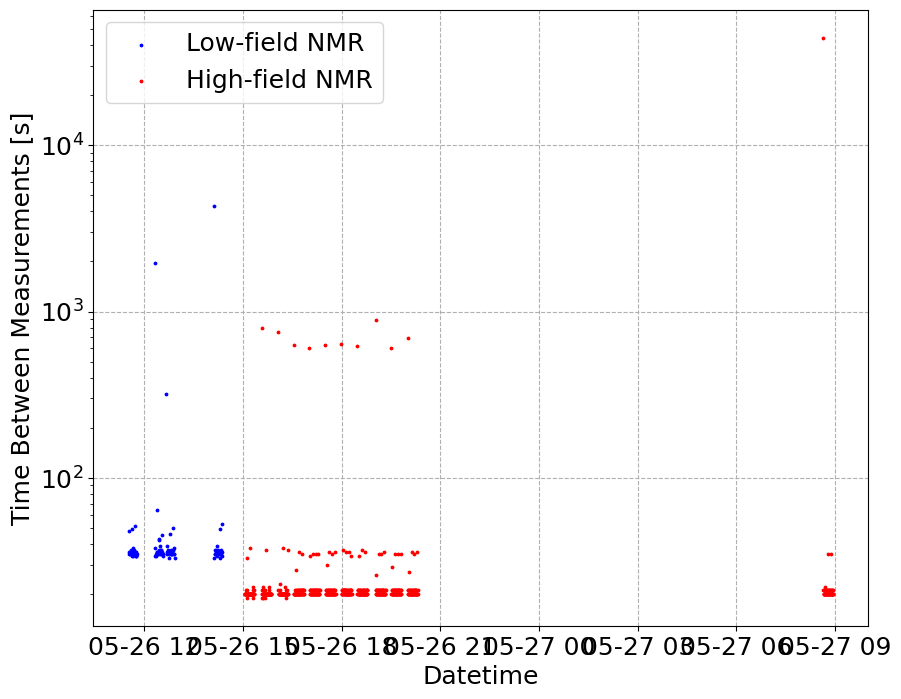

In [120]:
df_l = df_.query('nmr == "low"')
df_h = df_.query('nmr == "high"')

fig,ax = plt.subplots()

#ax.scatter(df_.index[1:], np.diff(df_.seconds_delta), s=3)
ax.scatter(df_l.index[1:], np.diff(df_l.seconds_delta), s=3, color='blue', label="Low-field NMR")
ax.scatter(df_h.index[1:], np.diff(df_h.seconds_delta), s=3, color='red', label="High-field NMR")

ax.set_yscale('log')
ax.legend()

ax.set_xlabel('Datetime')
ax.set_ylabel('Time Between Measurements [s]')

In [121]:
df_.columns

Index(['Time', 'Magnet Current [A]', 'Magnet Voltage [V]', 'NMR [T]',
       'NMR [FFT]', 'Zaber_Pattern_X', 'Zaber_Pattern_Y', 'Zaber_Pattern_Z',
       'Zaber_Meas_Encoder_X', 'Zaber_Meas_Micron_X', 'Zaber_Meas_Encoder_Y',
       'Zaber_Meas_Micron_Y', 'Zaber_Meas_Encoder_Z', 'Zaber_Meas_Micron_Z',
       'seconds_delta', 'hours_delta', 'days_delta', 'magnet_X_mm',
       'magnet_Y_mm', 'magnet_Z_mm', 'run_type', 'nmr', 'current', 'polarity',
       'Coil 1', 'Coil 2', 'LCW in Coil1', 'LCW out Coil 1', 'LCW in Coil 2',
       'LCW out Coil 2', 'Yoke (near pole)', 'Hall Element', 'Floor', 'Roof',
       'Yoke (center magnet)', 'Parameter HVAC sensor', 'Chamber Wall CH13',
       'Chamber Wall CH14', 'Chamber Wall CH15', 'Chamber Wall CH16',
       'Chamber Wall CH17', 'Chamber Wall CH18', 'Chamber Wall CH19',
       'Chamber Wall CH20', 'Desk Ambient', 'Outlet Strip Ambient',
       'Top fo Orange PS Ambient', 'Spare Ambient on desk',
       'TrippLite Ambient 3ft high', 'TrippLite Am

- Note I scan up in X and down in x, so looking at diff won't tell me when a new scan starts
- Shouldn't really matter, as long as I group similar currents into similar runs

Text(0, 0.5, 'X-step Size Between Measurements [mm]')

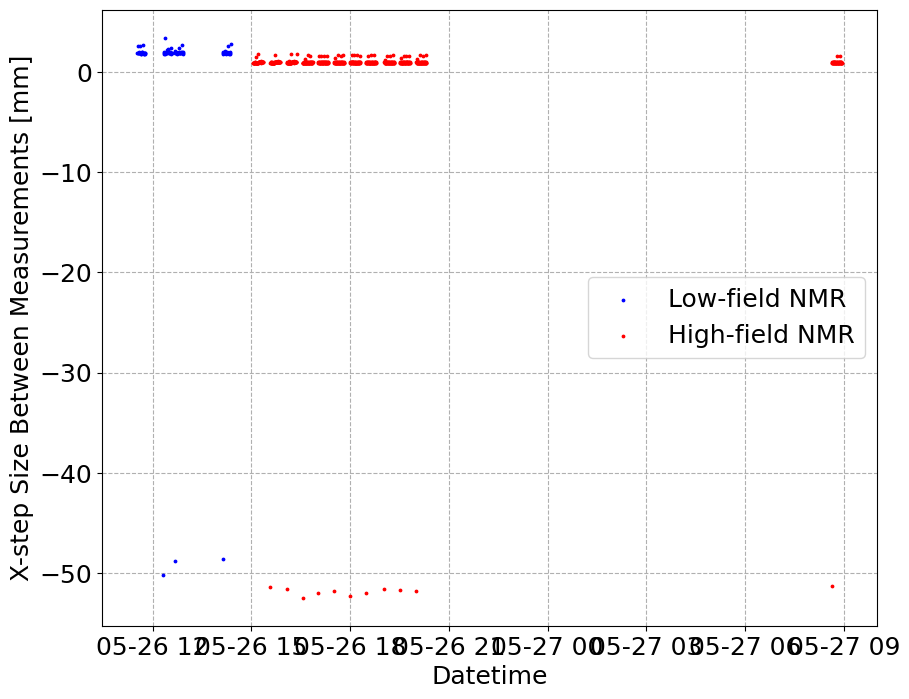

In [122]:
df_l = df_.query('nmr == "low"')
df_h = df_.query('nmr == "high"')

fig,ax = plt.subplots()

#ax.scatter(df_.index[1:], np.diff(df_.seconds_delta), s=3)
ax.scatter(df_l.index[1:], np.diff(df_l.magnet_X_mm), s=3, color='blue', label="Low-field NMR")
ax.scatter(df_h.index[1:], np.diff(df_h.magnet_X_mm), s=3, color='red', label="High-field NMR")

#ax.set_yscale('log')
ax.legend()

ax.set_xlabel('Datetime')
ax.set_ylabel('X-step Size Between Measurements [mm]')

Text(0, 0.5, 'Magnet Current [A]')

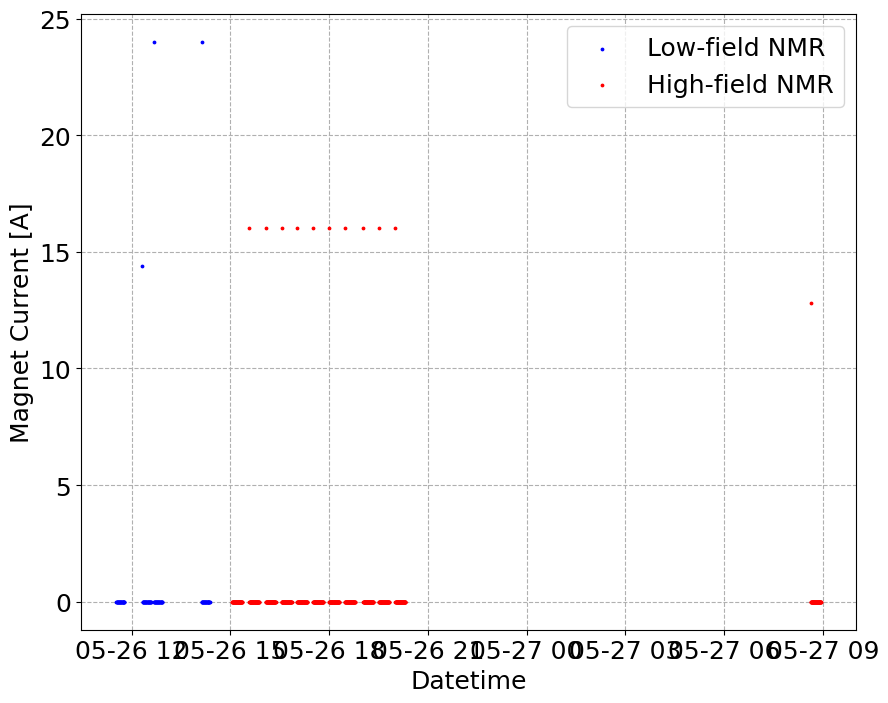

In [123]:
df_l = df_.query('nmr == "low"')
df_h = df_.query('nmr == "high"')

fig,ax = plt.subplots()

#ax.scatter(df_.index[1:], np.diff(df_.seconds_delta), s=3)
ax.scatter(df_l.index[1:], np.diff(df_l['Magnet Current [A]']), s=3, color='blue', label="Low-field NMR")
ax.scatter(df_h.index[1:], np.diff(df_h['Magnet Current [A]']), s=3, color='red', label="High-field NMR")

#ax.set_yscale('log')
ax.legend()

ax.set_xlabel('Datetime')
ax.set_ylabel('Magnet Current [A]')

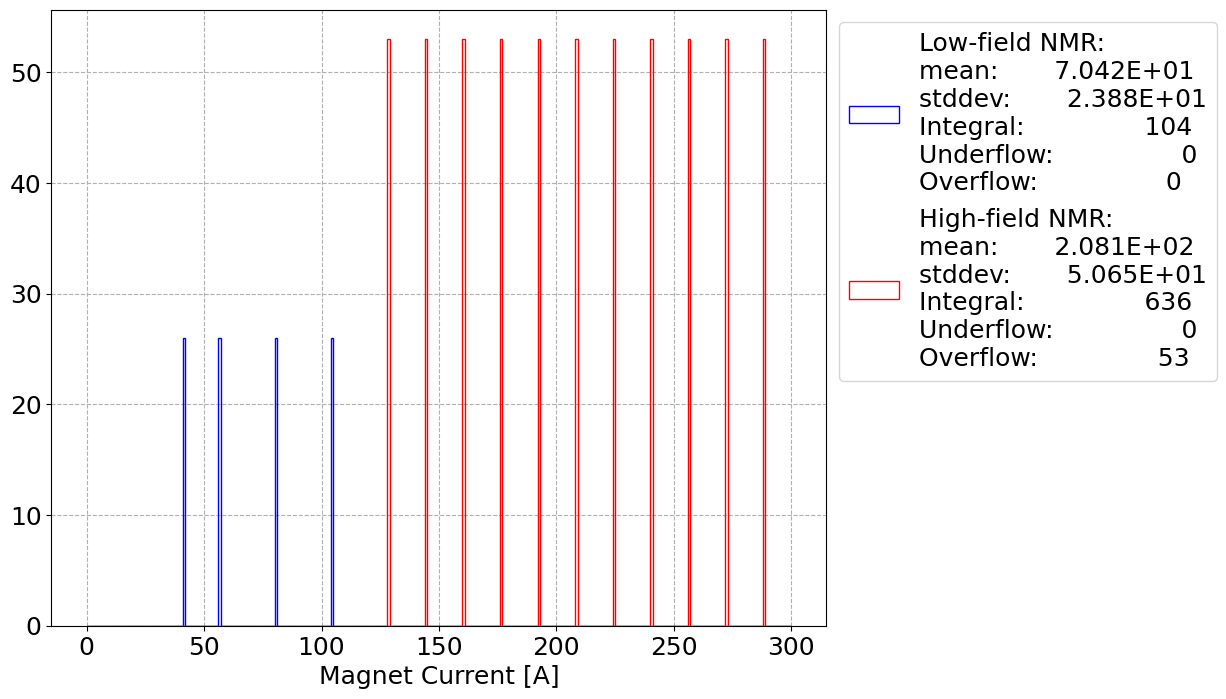

In [124]:
df_l = df_.query('nmr == "low"')
df_h = df_.query('nmr == "high"')

fig, ax = plt.subplots()

#bins=np.arange(-300., 300. + 10., 10.)
#bins=np.arange(0., 300. + 10., 10.)
bins=np.arange(0., 300. + 1., 1.)

ax.hist(df_l['Magnet Current [A]'], bins=bins, histtype='step', color='blue',
        label='Low-field NMR:\n'+get_label(df_l['Magnet Current [A]'], bins))

ax.hist(df_h['Magnet Current [A]'], bins=bins, histtype='step', color='red',
        label='High-field NMR:\n'+get_label(df_h['Magnet Current [A]'], bins))

ax.set_xlabel('Magnet Current [A]')
ax.legend(loc='upper left', bbox_to_anchor=(1.0,1.0))

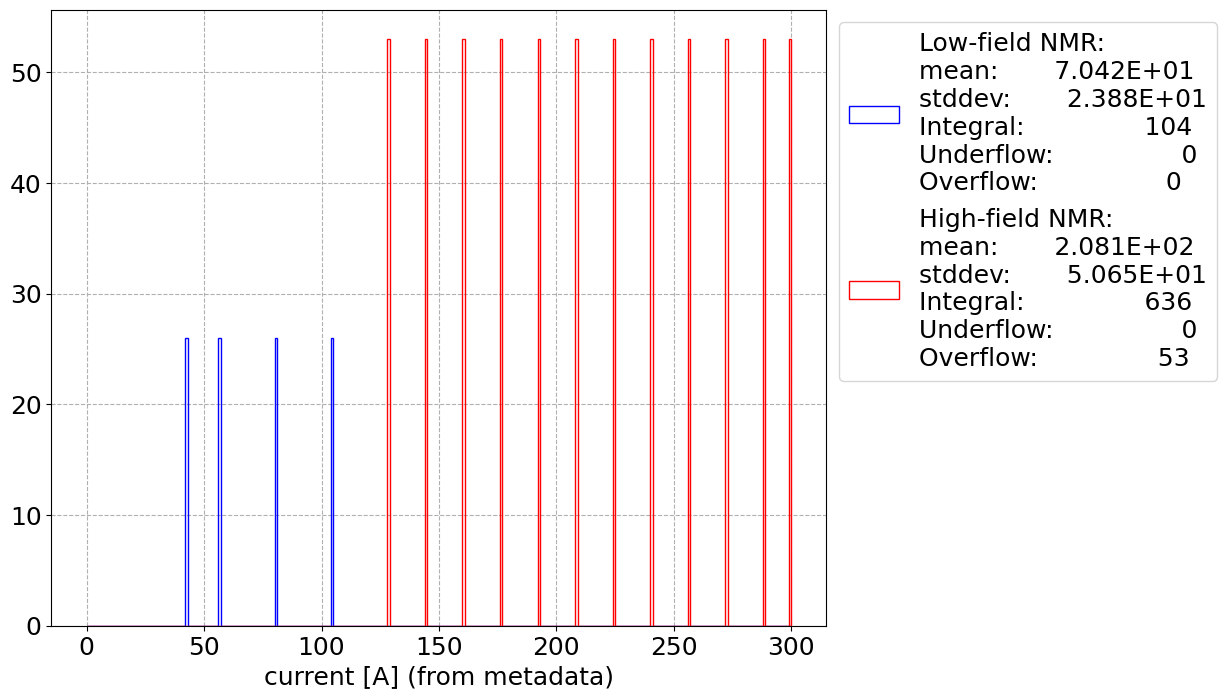

In [126]:
df_l = df_.query('nmr == "low"')
df_h = df_.query('nmr == "high"')

fig, ax = plt.subplots()

#bins=np.arange(-300., 300. + 10., 10.)
#bins=np.arange(0., 300. + 10., 10.)
bins=np.arange(0., 300. + 1., 1.)

ax.hist(df_l['current'], bins=bins, histtype='step', color='blue',
        label='Low-field NMR:\n'+get_label(df_l['Magnet Current [A]'], bins))

ax.hist(df_h['current'], bins=bins, histtype='step', color='red',
        label='High-field NMR:\n'+get_label(df_h['Magnet Current [A]'], bins))

ax.set_xlabel('current [A] (from metadata)')
ax.legend(loc='upper left', bbox_to_anchor=(1.0,1.0))

In [146]:
currents = sorted(df_.current.unique())
i = 1
current = currents[i]
df_run = df_.query(f'({current - 1.0} <= current <= {current + 1.0})')

In [147]:
df_run.magnet_X_mm

Datetime
2022-05-26 12:19:20    11.356354
2022-05-26 12:19:58    13.389799
2022-05-26 12:20:32    15.209197
2022-05-26 12:21:07    17.082107
2022-05-26 12:21:41    18.901505
2022-05-26 12:22:45    22.326254
2022-05-26 12:23:21    24.252675
2022-05-26 12:23:57    26.179097
2022-05-26 12:24:33    28.105518
2022-05-26 12:25:08    29.978428
2022-05-26 12:25:43    31.851338
2022-05-26 12:26:25    34.098829
2022-05-26 12:27:02    36.078762
2022-05-26 12:27:45    38.379766
2022-05-26 12:28:24    40.452855
2022-05-26 12:29:00    42.366477
2022-05-26 12:29:35    44.226942
2022-05-26 12:30:12    46.193719
2022-05-26 12:30:47    48.054184
2022-05-26 12:31:24    50.020962
2022-05-26 12:32:00    51.934583
2022-05-26 12:32:45    54.326609
2022-05-26 12:33:20    56.187075
2022-05-26 12:33:54    57.994384
2022-05-26 12:34:29    59.854849
2022-05-26 12:35:04    61.715314
Name: magnet_X_mm, dtype: float64

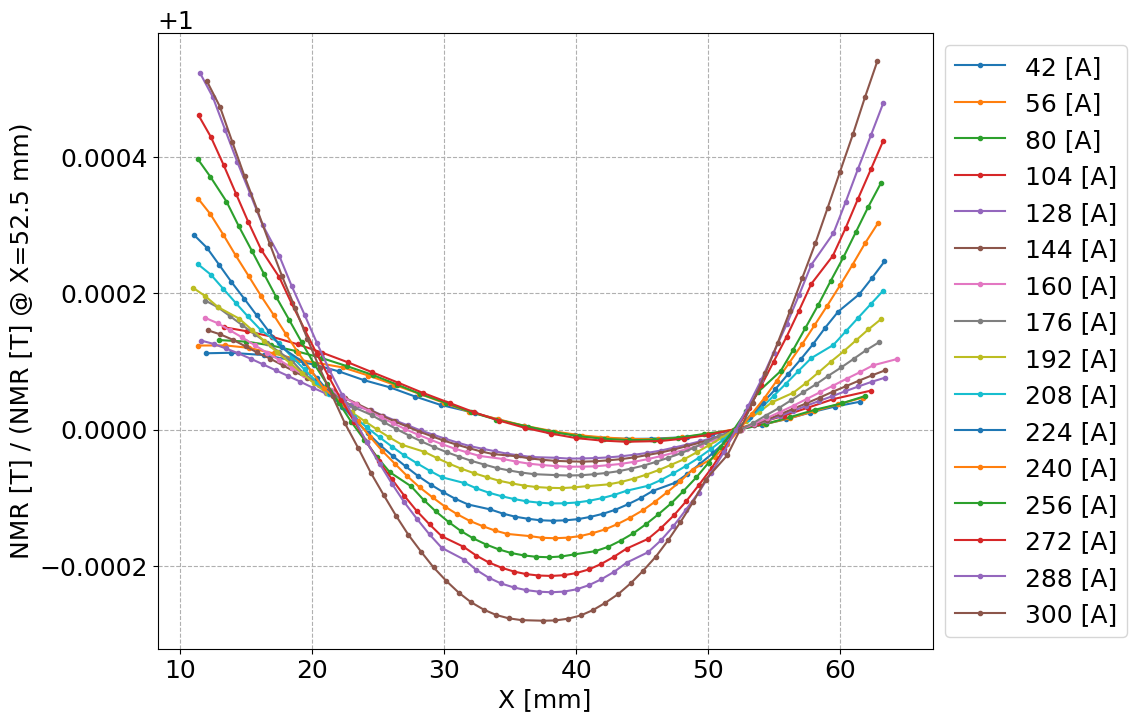

In [386]:
fig, ax = plt.subplots()

currents = sorted(df_.current.unique())
#i = 0

#x0_ = 40.0
# x0_ = 37.5
# with 15 mm horizontal adjustment
x0_ = 75./2. + 15.

ratios = []
ratios_ext = []
diffs = []
diffs_ext = []
vals = []
vals_ext = []
vals_Hall = []

x_ext = 3.

for i in range(len(currents)):
    # temp
    #if i < 4:
    #    continue
    current = currents[i]
    df_run = df_.query(f'({current - 1.0} <= current <= {current + 1.0})')
    xs = df_run['magnet_X_mm'].values
    ys = df_run['NMR [T]'].values
    interp_func = interp1d(xs, ys, kind='linear', fill_value='extrapolate')
    nmr = df_run.iloc[0]['nmr']
    if nmr == 'low':
        x0 = x0_
    else:
        x0 = x0_
    den = df_run.query(f'(({x0} - 1.0) <= magnet_X_mm <= ({x0} + 1.0))').iloc[0]['NMR [T]']
    #ax.scatter(df_run['magnet_X_mm'], df_run['NMR [T]']/den, s=3)
    ax.plot(df_run['magnet_X_mm'], df_run['NMR [T]']/den, 'o-', markersize=3, label=f'{current:0.0f} [A]')
    ratios.append(den/df_run.iloc[0]['NMR [T]'])
    ratios_ext.append(den/interp_func(x_ext))
    diffs.append(df_run.iloc[0]['NMR [T]'] - den)
    diffs_ext.append(interp_func(x_ext) - den)
    vals.append(df_run.iloc[0]['NMR [T]'])
    vals_ext.append(interp_func(x_ext))
    vals_Hall.append(den)

ratios = np.array(ratios)
ratios_ext = np.array(ratios_ext)
diffs = np.array(diffs)
diffs_ext = np.array(diffs_ext)
vals = np.array(vals)
vals_ext = np.array(vals_ext)
vals_Hall = np.array(vals_Hall)

ax.set_xlabel('X [mm]')
ax.set_ylabel(f'NMR [T] / (NMR [T] @ X={x0:0.1f} mm)')
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0));

(0.9982, 1.00005)

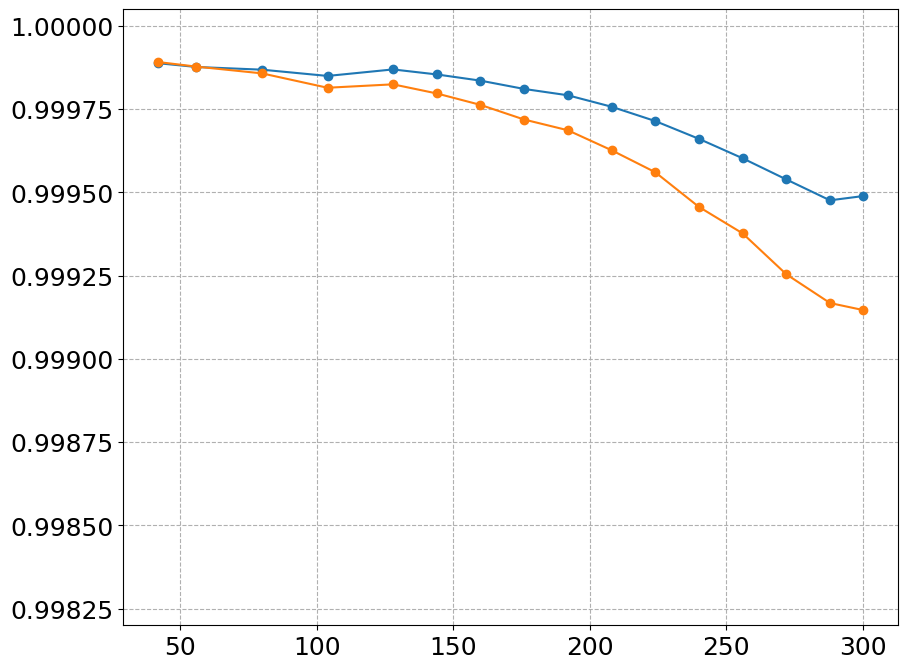

In [387]:
fig, ax = plt.subplots()

ax.plot(currents, ratios, 'o-')
ax.plot(currents, ratios_ext, 'o-')

ax.set_ylim([0.9982, 1.00005])

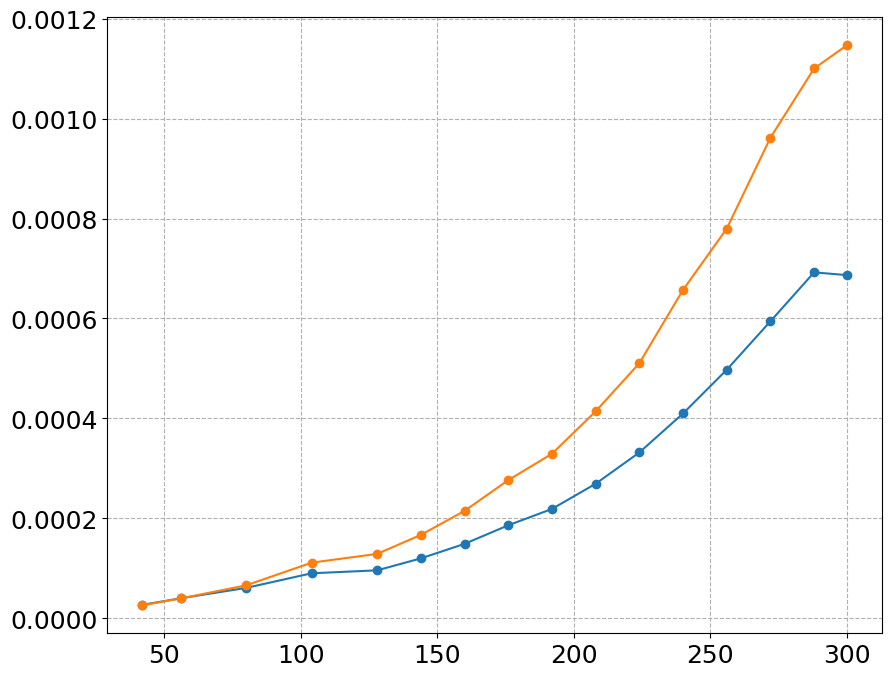

In [388]:
fig, ax = plt.subplots()

ax.plot(currents, diffs, 'o-')
ax.plot(currents, diffs_ext, 'o-')

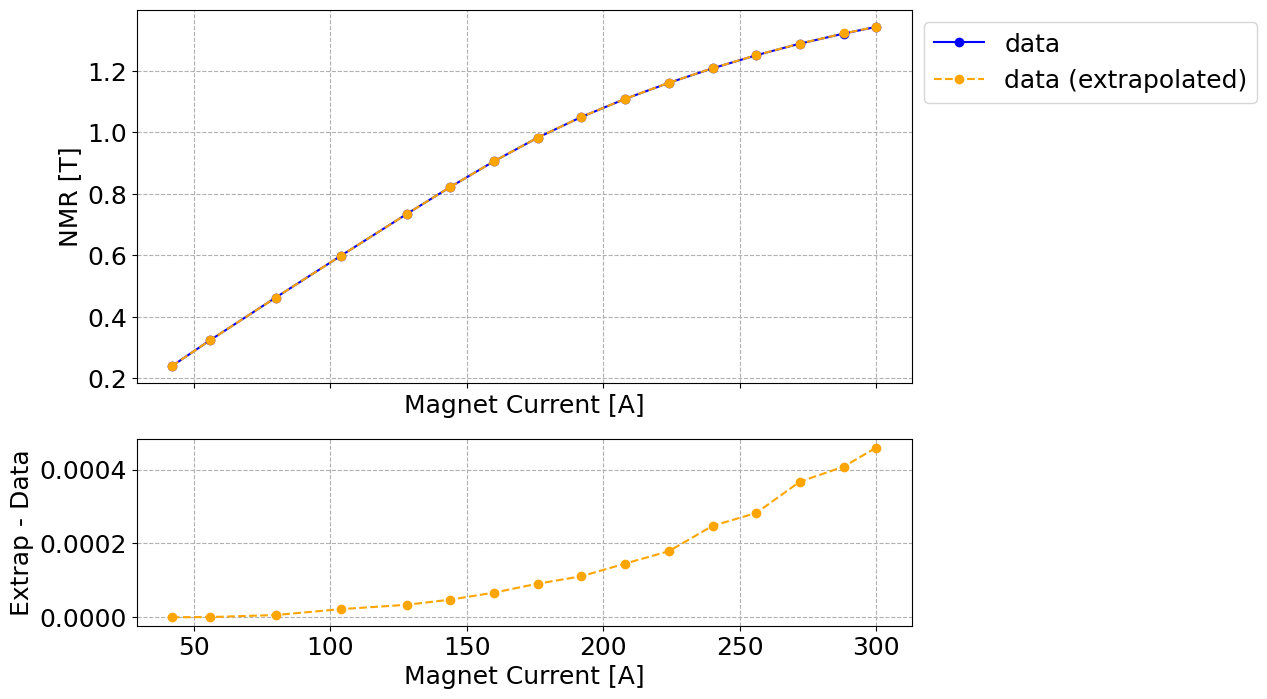

In [389]:
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw=dict(height_ratios=[2,1]))
ax, ax_r = axs

ax.plot(currents, vals, 'o-', color='blue', label='data')
ax.plot(currents, vals_ext, 'o--', color='orange', label='data (extrapolated)')

ax_r.plot(currents, vals_ext - vals, 'o--', color='orange')

ax_r.set_xlabel('Magnet Current [A]')
ax_r.set_ylabel('Extrap - Data')

ax.set_xlabel('Magnet Current [A]')
ax.set_ylabel('NMR [T]')
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0));

In [390]:
#interp_func_BEst = interp1d(currents, vals_ext, kind='cubic', fill_value='extrapolate')
interp_func_BEst = interp1d(currents, vals_Hall, kind='cubic', fill_value='extrapolate')

In [391]:
interp_func_BEst(110.)

array(0.63356263)

In [398]:
# USED FOR B ESTIMATION
pkl.dump(interp_func_BEst, open(ddir_proc+'BEst_from_pole_to_pole.pkl', 'wb'))

In [372]:
pkldir_BEst = ('/home/ckampa/data/hallprobecalib_extras/datafiles/magnet_ramp/'+
               '2021-02-24/')
f = pkldir_BEst+'ramp_2021-02-24.interp_fcn_NMR.pkl'
func = pkl.load(open(f,'rb')) # may need to rerun this analysis to update scipy interp
f_H = pkldir_BEst+'ramp_2021-02-24.interp_fcn_Hall.pkl'
func_H = pkl.load(open(f_H,'rb')) # may need to rerun this analysis to update scipy interp

/tmp/ipykernel_2207511/2198248178.py:4: DeprecationWarning:

Please import `interp1d` from the `scipy.interpolate` namespace; the `scipy.interpolate.interpolate` namespace is deprecated and will be removed in SciPy 2.0.0.

/tmp/ipykernel_2207511/2198248178.py:6: DeprecationWarning:

Please import `interp1d` from the `scipy.interpolate` namespace; the `scipy.interpolate.interpolate` namespace is deprecated and will be removed in SciPy 2.0.0.



In [393]:
func(110.)

array(0.63183128)

In [394]:
func_H(110.)

array(0.63267722)

In [395]:
interp_func_BEst(110.) - func_H(110.)

0.0008854108112998915

In [396]:
interp_func_BEst(150.) - func_H(150.)

0.0005883151913222973

In [351]:
params = np.polyfit(currents, diffs_ext, deg=3)
poly_func = np.polynomial.Polynomial(params[::-1])

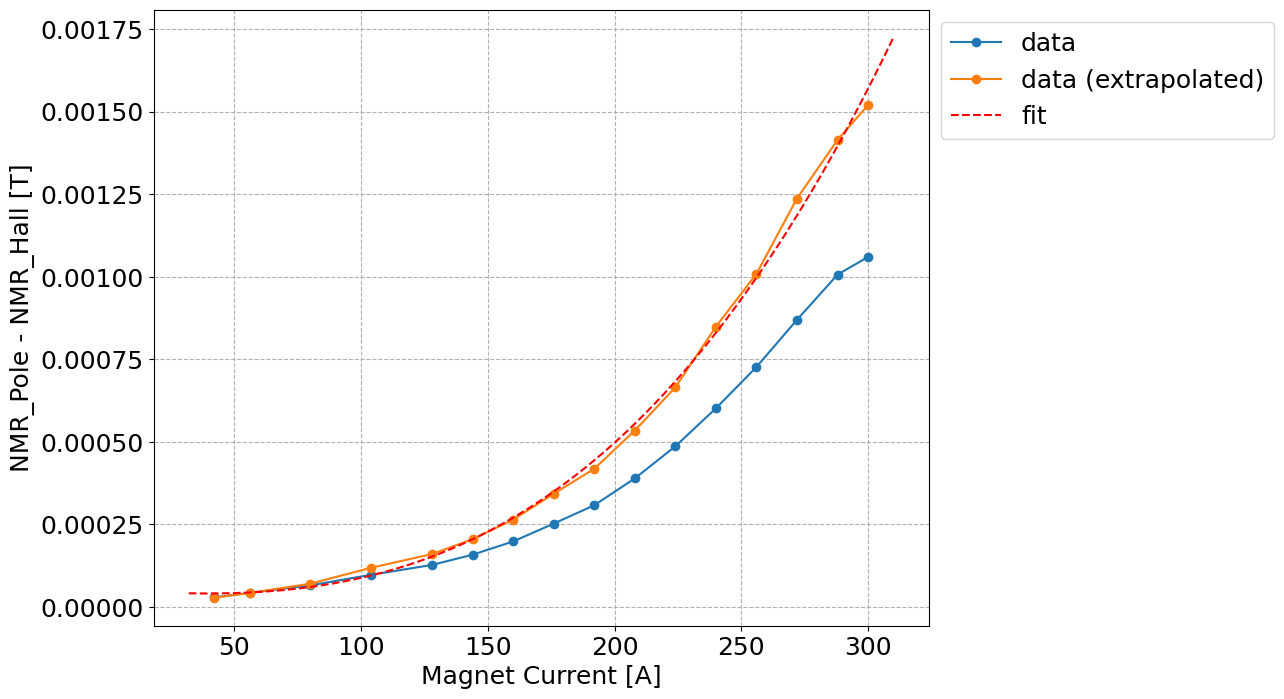

In [352]:
fig, ax = plt.subplots()

ax.plot(currents, diffs, 'o-', label='data')
ax.plot(currents, diffs_ext, 'o-', label='data (extrapolated)')
cs_fit = np.linspace(np.min(currents)-10., np.max(currents)+10., 500)
ax.plot(cs_fit, poly_func(cs_fit), 'r--', label='fit')

ax.set_xlabel('Magnet Current [A]')
ax.set_ylabel('NMR_Pole - NMR_Hall [T]')
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0));

In [354]:
ddir_proc

'/home/ckampa/data/hallprobecalib_extras/datafiles/Thesis_Calibration/'

In [356]:
params

array([ 4.80981429e-11,  4.28374374e-09, -5.60662879e-07,  5.33649135e-05])

In [357]:
# THIS IS WHAT I LOAD INTO CALIBRATION
pkl.dump(params, open(ddir_proc+f'params_B_corr_func_linear_interp_extrap_xHall_{x0:0.1f}.pkl', 'wb'))

In [312]:
currents = sorted(df_.current.unique())
#i = 0
#i = 2
#i = 3
# i = 4
i = 5
current = currents[i]
df_run = df_.query(f'({current - 1.0} <= current <= {current + 1.0})')

In [313]:
df_run

,Time,Magnet Current [A],Magnet Voltage [V],NMR [T],NMR [FFT],Zaber_Pattern_X,Zaber_Pattern_Y,Zaber_Pattern_Z,Zaber_Meas_Encoder_X,Zaber_Meas_Micron_X,...,Tripplite HVAC exhaust,EvapCoil (NWC),Barrel/Reservoir (FNAL),Return PS (FNAL),Return Magnet (NWC-R),Chiller Exhaust (NW),Supply Magnet (NWC-S),Supply PS (FNAL),has_nmr,run_index_slow
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-05-26 15:34:24,5/26/2022 3:34:24 PM,144.041190,16.016177,0.823041,0.0,424505.0,426431.0,1664882.0,424505.0,165822.265625,...,34.873278,23.023360,22.247529,33.163487,4.616586,31.614202,1.568971,23.019208,0.0,0.0
2022-05-26 15:34:44,5/26/2022 3:34:44 PM,144.041182,16.017882,0.823036,0.0,427065.0,426431.0,1664882.0,427065.0,166822.265625,...,34.992303,23.027666,22.249702,33.167764,4.606412,31.517387,1.591731,23.020940,0.0,0.0
2022-05-26 15:35:05,5/26/2022 3:35:05 PM,144.041174,16.019672,0.823030,0.0,429625.0,426431.0,1664882.0,429625.0,167822.265625,...,35.117279,23.032187,22.251984,33.172254,4.595728,31.415732,1.615630,23.022760,0.0,0.0
2022-05-26 15:35:25,5/26/2022 3:35:25 PM,144.041166,16.021377,0.823022,0.0,432185.0,426431.0,1664882.0,432185.0,168822.265625,...,35.236305,23.036493,22.254156,33.176531,4.585553,31.318918,1.638391,23.024492,0.0,0.0
2022-05-26 15:35:44,5/26/2022 3:35:44 PM,144.041159,16.022997,0.823014,0.0,434745.0,426431.0,1664882.0,434745.0,169822.265625,...,35.349378,23.040583,22.256220,33.180594,4.575887,31.226944,1.660013,23.026138,0.0,0.0
2022-05-26 15:36:05,5/26/2022 3:36:05 PM,144.041151,16.024788,0.823007,0.0,437305.0,426431.0,1664882.0,437305.0,170822.265625,...,35.474355,23.045104,22.258502,33.185084,4.565204,31.125289,1.683912,23.027958,0.0,0.0
2022-05-26 15:36:25,5/26/2022 3:36:25 PM,144.041144,16.026493,0.822999,0.0,439865.0,426431.0,1664882.0,439865.0,171822.265625,...,35.593380,23.049410,22.260674,33.189361,4.555029,31.028474,1.706673,23.029690,0.0,0.0
2022-05-26 15:36:45,5/26/2022 3:36:45 PM,144.041136,16.028198,0.822991,0.0,442425.0,426431.0,1664882.0,442425.0,172822.265625,...,35.712405,23.053716,22.262847,33.193637,4.544855,30.931660,1.729434,23.031423,0.0,0.0
2022-05-26 15:37:05,5/26/2022 3:37:05 PM,144.041128,16.029903,0.822983,0.0,444985.0,426431.0,1664882.0,444985.0,173822.265625,...,35.831431,23.058022,22.265020,33.197914,4.534680,30.834845,1.752194,23.033156,0.0,0.0


In [314]:
x0 = 40.
xs = df_run['magnet_X_mm'].values
ys = df_run['NMR [T]'].values

In [315]:
interp_func = interp1d(xs, ys, kind='linear', fill_value='extrapolate')
# interp_func = interp1d(xs, ys, kind='quadratic', fill_value='extrapolate')
# interp_func = interp1d(xs, ys, kind='cubic', fill_value='extrapolate')

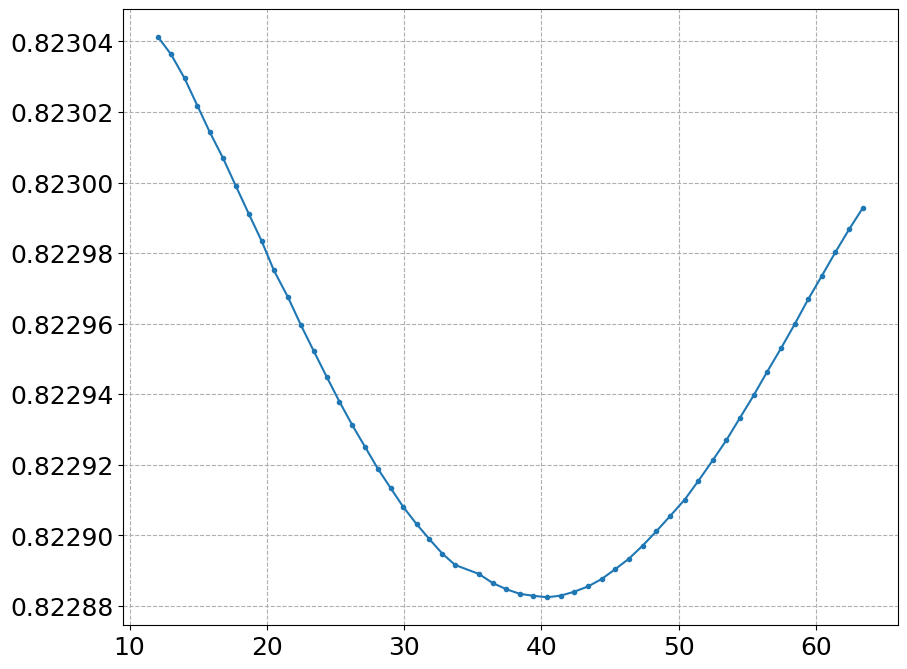

In [316]:
fig, ax = plt.subplots()

ax.plot(xs, ys, 'o-', markersize=3)

In [317]:
xs[True]

array([[12.08766304, 13.02414402, 14.00744905, 14.94393003, 15.83358696,
        16.81689198, 17.75337296, 18.68985394, 19.62633492, 20.51599185,
        21.54612092, 22.4826019 , 23.41908288, 24.35556386, 25.29204484,
        26.22852582, 27.16500679, 28.10148777, 29.03796875, 29.92762568,
        30.91093071, 31.84741168, 32.78389266, 33.72037364, 35.45286345,
        36.44339611, 37.43677359, 38.43015108, 39.42352856, 40.41690604,
        41.41028353, 42.40366101, 43.39703849, 44.39041598, 45.38379346,
        46.37717094, 47.37054843, 48.36392591, 49.35730339, 50.45001863,
        51.44339611, 52.48644247, 53.47981995, 54.47319743, 55.46657492,
        56.4599524 , 57.45332988, 58.44670737, 59.44008485, 60.43346233,
        61.42683982, 62.4202173 , 63.41359478]])

In [318]:
xs

array([12.08766304, 13.02414402, 14.00744905, 14.94393003, 15.83358696,
       16.81689198, 17.75337296, 18.68985394, 19.62633492, 20.51599185,
       21.54612092, 22.4826019 , 23.41908288, 24.35556386, 25.29204484,
       26.22852582, 27.16500679, 28.10148777, 29.03796875, 29.92762568,
       30.91093071, 31.84741168, 32.78389266, 33.72037364, 35.45286345,
       36.44339611, 37.43677359, 38.43015108, 39.42352856, 40.41690604,
       41.41028353, 42.40366101, 43.39703849, 44.39041598, 45.38379346,
       46.37717094, 47.37054843, 48.36392591, 49.35730339, 50.45001863,
       51.44339611, 52.48644247, 53.47981995, 54.47319743, 55.46657492,
       56.4599524 , 57.45332988, 58.44670737, 59.44008485, 60.43346233,
       61.42683982, 62.4202173 , 63.41359478])

In [319]:
# m = True # all points
m = (xs < 45.)
params = np.polyfit(xs[m]-x0, ys[m], deg=3)
params

array([4.93920047e-09, 3.58031398e-07, 2.96828823e-07, 8.22881335e-01])

In [320]:
poly_func = np.polynomial.Polynomial(params[::-1])

In [321]:
poly_func

Polynomial([8.22881335e-01, 2.96828823e-07, 3.58031398e-07, 4.93920047e-09], domain=[-1,  1], window=[-1,  1], symbol='x')

In [322]:
poly_func(xs-x0)

array([0.82304458, 0.82303691, 0.82302877, 0.82302098, 0.82301355,
       0.82300534, 0.82299754, 0.8229898 , 0.82298213, 0.82297494,
       0.82296674, 0.82295945, 0.82295233, 0.82294541, 0.82293871,
       0.82293225, 0.82292606, 0.82292017, 0.8229146 , 0.82290962,
       0.82290451, 0.82290004, 0.82289598, 0.82289237, 0.82288692,
       0.82288459, 0.82288284, 0.82288173, 0.82288128, 0.82288152,
       0.82288248, 0.82288419, 0.82288667, 0.82288996, 0.82289408,
       0.82289907, 0.82290495, 0.82291175, 0.82291951, 0.82292917,
       0.82293902, 0.82295048, 0.82296249, 0.8229756 , 0.82298985,
       0.82300525, 0.82302184, 0.82303965, 0.8230587 , 0.82307903,
       0.82310066, 0.82312362, 0.82314795])

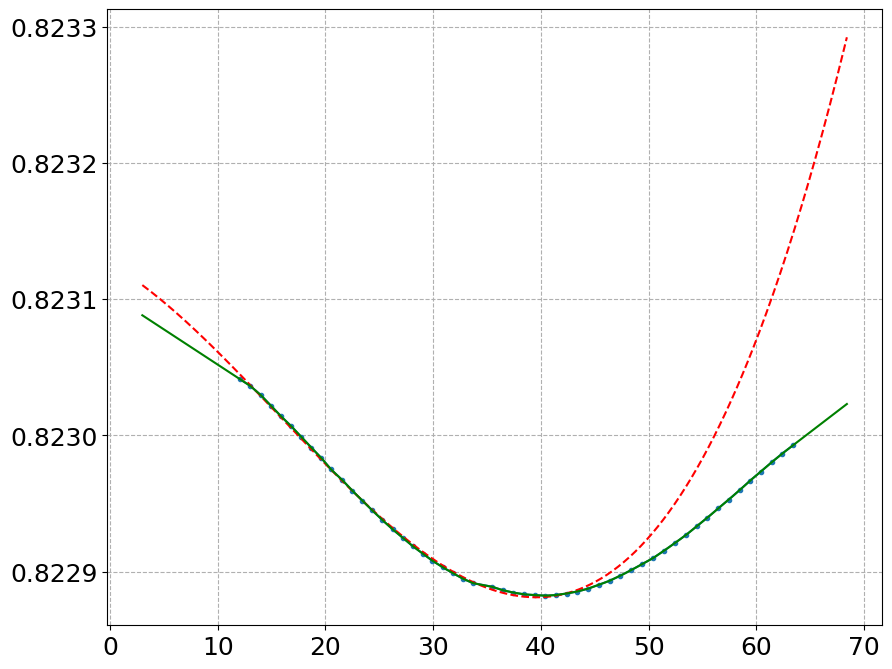

In [323]:
fig, ax = plt.subplots()

ax.plot(xs, ys, 'o-', markersize=3, label='data')

#xs_fit = np.linspace(xs.min() - 5., xs.max() + 5., 500)
xs_fit = np.linspace(3., xs.max() + 5., 500)
ax.plot(xs_fit, poly_func(xs_fit-x0), '--', color='red', label='fit')
ax.plot(xs_fit, interp_func(xs_fit), '-', color='green', label='interpolation (quadratic)')

In [171]:
xs

array([12.08766304, 13.02414402, 14.00744905, 14.94393003, 15.83358696,
       16.81689198, 17.75337296, 18.68985394, 19.62633492, 20.51599185,
       21.54612092, 22.4826019 , 23.41908288, 24.35556386, 25.29204484,
       26.22852582, 27.16500679, 28.10148777, 29.03796875, 29.92762568,
       30.91093071, 31.84741168, 32.78389266, 33.72037364, 35.45286345,
       36.44339611, 37.43677359, 38.43015108, 39.42352856, 40.41690604,
       41.41028353, 42.40366101, 43.39703849, 44.39041598, 45.38379346,
       46.37717094, 47.37054843, 48.36392591, 49.35730339, 50.45001863,
       51.44339611, 52.48644247, 53.47981995, 54.47319743, 55.46657492,
       56.4599524 , 57.45332988, 58.44670737, 59.44008485, 60.43346233,
       61.42683982, 62.4202173 , 63.41359478])

In [162]:
lm.Model()

NameError: name 'lm' is not defined

In [139]:
den

Time                     5/26/2022 11:40:07 AM
Magnet Current [A]                   41.611214
Magnet Voltage [V]                    4.455779
NMR [T]                                0.24013
NMR [FFT]                                  0.0
                                 ...          
Chiller Exhaust (NW)                 30.748633
Supply Magnet (NWC-S)                 2.007297
Supply PS (FNAL)                     21.963861
has_nmr                                    0.0
run_index_slow                             0.0
Name: 2022-05-26 11:40:07, Length: 64, dtype: object

In [134]:
df_run

,Time,Magnet Current [A],Magnet Voltage [V],NMR [T],NMR [FFT],Zaber_Pattern_X,Zaber_Pattern_Y,Zaber_Pattern_Z,Zaber_Meas_Encoder_X,Zaber_Meas_Micron_X,...,Tripplite HVAC exhaust,EvapCoil (NWC),Barrel/Reservoir (FNAL),Return PS (FNAL),Return Magnet (NWC-R),Chiller Exhaust (NW),Supply Magnet (NWC-S),Supply PS (FNAL),has_nmr,run_index_slow
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-05-26 11:31:22,5/26/2022 11:31:22 AM,41.611231,4.461720,0.240159,0.0,426758.0,426431.0,1718667.0,426758.0,166702.34375,...,41.423291,22.775613,21.527992,26.234833,2.844532,28.499512,1.705608,22.197491,0.0,0.0
2022-05-26 11:31:57,5/26/2022 11:31:57 AM,41.611233,4.461289,0.240159,0.0,431878.0,426431.0,1718667.0,431878.0,168702.34375,...,40.447357,22.780661,21.514526,26.228505,2.828768,28.580240,1.740668,22.181016,0.0,0.0
2022-05-26 11:32:45,5/26/2022 11:32:45 AM,41.611234,4.460697,0.240158,0.0,436998.0,426431.0,1718667.0,436998.0,170702.34375,...,39.108933,22.787584,21.496057,26.219828,2.807150,28.690954,1.788751,22.158421,0.0,0.0
2022-05-26 11:33:21,5/26/2022 11:33:21 AM,41.611236,4.460253,0.240157,0.0,442118.0,426431.0,1718667.0,442118.0,172702.34375,...,38.105114,22.792777,21.482206,26.213319,2.790936,28.773989,1.824813,22.141474,0.0,0.0
2022-05-26 11:33:56,5/26/2022 11:33:56 AM,41.611237,4.459821,0.240155,0.0,447238.0,426431.0,1718667.0,447238.0,174702.34375,...,37.129180,22.797825,21.468740,26.206992,2.775172,28.854718,1.859873,22.124999,0.0,0.0
2022-05-26 11:34:31,5/26/2022 11:34:31 AM,41.611238,4.459390,0.240153,0.0,452358.0,426431.0,1718667.0,452358.0,176702.34375,...,36.153245,22.802873,21.455274,26.200664,2.759409,28.935447,1.894934,22.108523,0.0,0.0
2022-05-26 11:35:07,5/26/2022 11:35:07 AM,41.611240,4.458946,0.240150,0.0,457478.0,426431.0,1718667.0,457478.0,178702.34375,...,35.149427,22.808065,21.441423,26.194156,2.743195,29.018482,1.930996,22.091577,0.0,0.0
2022-05-26 11:35:44,5/26/2022 11:35:44 AM,41.611241,4.458489,0.240147,0.0,462598.0,426431.0,1718667.0,462598.0,180702.34375,...,34.117725,22.813401,21.427187,26.187467,2.726531,29.103824,1.968059,22.074160,0.0,0.0
2022-05-26 11:36:20,5/26/2022 11:36:20 AM,41.611242,4.458045,0.240144,0.0,467718.0,426431.0,1718667.0,467718.0,182702.34375,...,33.113907,22.818594,21.413336,26.180959,2.710317,29.186859,2.004121,22.057214,0.0,0.0


In [85]:
df_h.columns

Index(['Time', 'Magnet Current [A]', 'Magnet Voltage [V]', 'NMR [T]',
       'NMR [FFT]', 'Zaber_Pattern_X', 'Zaber_Pattern_Y', 'Zaber_Pattern_Z',
       'Zaber_Meas_Encoder_X', 'Zaber_Meas_Micron_X', 'Zaber_Meas_Encoder_Y',
       'Zaber_Meas_Micron_Y', 'Zaber_Meas_Encoder_Z', 'Zaber_Meas_Micron_Z',
       'seconds_delta', 'hours_delta', 'days_delta', 'magnet_X_mm',
       'magnet_Y_mm', 'magnet_Z_mm', 'run_type', 'nmr', 'current', 'polarity',
       'Coil 1', 'Coil 2', 'LCW in Coil1', 'LCW out Coil 1', 'LCW in Coil 2',
       'LCW out Coil 2', 'Yoke (near pole)', 'Hall Element', 'Floor', 'Roof',
       'Yoke (center magnet)', 'Parameter HVAC sensor', 'Chamber Wall CH13',
       'Chamber Wall CH14', 'Chamber Wall CH15', 'Chamber Wall CH16',
       'Chamber Wall CH17', 'Chamber Wall CH18', 'Chamber Wall CH19',
       'Chamber Wall CH20', 'Desk Ambient', 'Outlet Strip Ambient',
       'Top fo Orange PS Ambient', 'Spare Ambient on desk',
       'TrippLite Ambient 3ft high', 'TrippLite Am

In [82]:
df_h.query('`Magnet Current [A]` < 110')

,Time,Magnet Current [A],Magnet Voltage [V],NMR [T],NMR [FFT],Zaber_Pattern_X,Zaber_Pattern_Y,Zaber_Pattern_Z,Zaber_Meas_Encoder_X,Zaber_Meas_Micron_X,...,Tripplite HVAC exhaust,EvapCoil (NWC),Barrel/Reservoir (FNAL),Return PS (FNAL),Return Magnet (NWC-R),Chiller Exhaust (NW),Supply Magnet (NWC-S),Supply PS (FNAL),has_nmr,run_index_slow
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-05-26 15:18:45,5/26/2022 3:18:45 PM,103.265472,11.214424,0.734720,0.0,539705.0,426431.0,1664882.0,510737.483221,199506.829383,...,35.361574,23.080235,22.164628,31.916018,4.168633,30.199520,1.860726,22.944732,0.0,0.0
2022-05-26 15:19:05,5/26/2022 3:19:05 PM,94.868641,10.213577,0.734726,0.0,542265.0,426431.0,1664882.0,503521.375839,196688.037437,...,35.483394,23.075265,22.168397,31.700301,4.151285,30.121102,1.879099,22.948128,0.0,0.0
2022-05-26 15:19:25,5/26/2022 3:19:25 PM,86.471810,9.212729,0.734731,0.0,544825.0,426431.0,1664882.0,496305.268456,193869.245491,...,35.605214,23.070294,22.172166,31.484583,4.133938,30.042684,1.897473,22.951525,0.0,0.0
2022-05-26 15:19:45,5/26/2022 3:19:45 PM,78.074979,8.211882,0.734736,0.0,547385.0,426431.0,1664882.0,489089.161074,191050.453544,...,35.727033,23.065324,22.175935,31.268866,4.116590,29.964266,1.915846,22.954921,0.0,0.0
2022-05-26 15:20:05,5/26/2022 3:20:05 PM,69.678148,7.211034,0.734741,0.0,549945.0,426431.0,1664882.0,481873.053691,188231.661598,...,35.848853,23.060353,22.179704,31.053149,4.099243,29.885848,1.934220,22.958318,0.0,0.0
2022-05-26 15:20:25,5/26/2022 3:20:25 PM,61.281317,6.210186,0.734747,0.0,552505.0,426431.0,1664882.0,474656.946309,185412.869652,...,35.970673,23.055383,22.183473,30.837432,4.081896,29.807430,1.952593,22.961715,0.0,0.0
2022-05-26 15:20:45,5/26/2022 3:20:45 PM,52.884486,5.209339,0.734752,0.0,555065.0,426431.0,1664882.0,467440.838926,182594.077706,...,36.092493,23.050412,22.187242,30.621715,4.064548,29.729012,1.970966,22.965111,0.0,0.0
2022-05-26 15:21:06,5/26/2022 3:21:06 PM,44.067814,4.158449,0.734756,0.0,557625.0,426431.0,1664882.0,459863.926174,179634.346162,...,36.220404,23.045193,22.191199,30.395212,4.046333,29.646673,1.990258,22.968678,0.0,0.0
2022-05-26 16:49:48,5/26/2022 4:49:48 PM,106.919445,11.553664,0.983234,0.0,544825.0,426431.0,1664882.0,486494.798658,190037.030726,...,42.077860,23.079786,22.622074,32.481519,5.563861,29.992064,1.919351,23.467419,0.0,0.0


In [83]:
df_h.query('(0.98 <= `NMR [T]` <= 0.99)')

,Time,Magnet Current [A],Magnet Voltage [V],NMR [T],NMR [FFT],Zaber_Pattern_X,Zaber_Pattern_Y,Zaber_Pattern_Z,Zaber_Meas_Encoder_X,Zaber_Meas_Micron_X,...,Tripplite HVAC exhaust,EvapCoil (NWC),Barrel/Reservoir (FNAL),Return PS (FNAL),Return Magnet (NWC-R),Chiller Exhaust (NW),Supply Magnet (NWC-S),Supply PS (FNAL),has_nmr,run_index_slow
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-05-26 16:33:16,5/26/2022 4:33:16 PM,176.049792,19.970229,0.983355,0.0,424505.0,426431.0,1664882.0,428031.357616,167199.749069,...,42.229450,23.036144,22.578746,34.263480,5.104597,33.131002,2.242564,23.404083,0.0,0.0
2022-05-26 16:33:36,5/26/2022 4:33:36 PM,176.049687,19.974709,0.983346,0.0,427065.0,426431.0,1664882.0,430235.331126,168060.676221,...,41.926479,23.042074,22.579479,34.269049,5.126868,33.129206,2.227469,23.404092,0.0,0.0
2022-05-26 16:33:56,5/26/2022 4:33:56 PM,176.049582,19.979190,0.983333,0.0,429625.0,426431.0,1664882.0,432439.304636,168921.603373,...,41.623508,23.048004,22.580212,34.274618,5.149138,33.127410,2.212374,23.404101,0.0,0.0
2022-05-26 16:34:16,5/26/2022 4:34:16 PM,176.049477,19.983671,0.983319,0.0,432185.0,426431.0,1664882.0,434643.278146,169782.530526,...,41.320537,23.053935,22.580944,34.280187,5.171408,33.125613,2.197279,23.404110,0.0,0.0
2022-05-26 16:34:36,5/26/2022 4:34:36 PM,176.049372,19.988151,0.983307,0.0,434745.0,426431.0,1664882.0,436847.251656,170643.457678,...,41.017566,23.059865,22.581677,34.285756,5.193679,33.123817,2.182184,23.404119,0.0,0.0
2022-05-26 16:34:56,5/26/2022 4:34:56 PM,176.049266,19.992632,0.983294,0.0,437305.0,426431.0,1664882.0,439051.225166,171504.384830,...,40.714595,23.065795,22.582410,34.291325,5.215949,33.122020,2.167089,23.404128,0.0,0.0
2022-05-26 16:35:16,5/26/2022 4:35:16 PM,176.049161,19.997112,0.983281,0.0,439865.0,426431.0,1664882.0,441255.198675,172365.311983,...,40.411625,23.071726,22.583143,34.296894,5.238219,33.120224,2.151994,23.404137,0.0,0.0
2022-05-26 16:35:37,5/26/2022 4:35:37 PM,176.049051,20.001817,0.983268,0.0,442425.0,426431.0,1664882.0,443569.370861,173269.285493,...,40.093505,23.077953,22.583912,34.302741,5.261603,33.118338,2.136144,23.404147,0.0,0.0
2022-05-26 16:35:57,5/26/2022 4:35:57 PM,176.048946,20.006298,0.983249,0.0,444985.0,426431.0,1664882.0,445773.344371,174130.212645,...,39.790534,23.083883,22.584645,34.308310,5.283873,33.116541,2.121049,23.404156,0.0,0.0


In [84]:
df_.query('("2022-05-26 16:20" <= `Datetime` <= "2022-05-26 17:15")')

,Time,Magnet Current [A],Magnet Voltage [V],NMR [T],NMR [FFT],Zaber_Pattern_X,Zaber_Pattern_Y,Zaber_Pattern_Z,Zaber_Meas_Encoder_X,Zaber_Meas_Micron_X,...,Tripplite HVAC exhaust,EvapCoil (NWC),Barrel/Reservoir (FNAL),Return PS (FNAL),Return Magnet (NWC-R),Chiller Exhaust (NW),Supply Magnet (NWC-S),Supply PS (FNAL),has_nmr,run_index_slow
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-05-26 16:20:06,5/26/2022 4:20:06 PM,160.044917,18.071084,0.906465,0.0,539705.0,426431.0,1664882.0,538566.270903,210377.449571,...,35.560553,23.239520,22.490874,33.878478,5.060754,30.507252,1.825628,23.315155,0.0,0.0
2022-05-26 16:20:26,5/26/2022 4:20:26 PM,160.044909,18.072403,0.906474,0.0,542265.0,426431.0,1664882.0,540963.595318,211313.904421,...,36.076177,23.225667,22.494631,33.873750,5.055238,30.370213,1.838868,23.317895,0.0,0.0
2022-05-26 16:20:46,5/26/2022 4:20:46 PM,160.044902,18.073723,0.906482,0.0,544825.0,426431.0,1664882.0,543360.919732,212250.359270,...,36.591801,23.211815,22.498388,33.869023,5.049723,30.233174,1.852107,23.320635,0.0,0.0
2022-05-26 16:21:06,5/26/2022 4:21:06 PM,160.044894,18.075042,0.906491,0.0,547385.0,426431.0,1664882.0,545758.244147,213186.814120,...,37.107425,23.197962,22.502144,33.864296,5.044207,30.096136,1.865347,23.323376,0.0,0.0
2022-05-26 16:21:27,5/26/2022 4:21:27 PM,160.044886,18.076427,0.906501,0.0,549945.0,426431.0,1664882.0,548275.434783,214170.091712,...,37.648830,23.183417,22.506089,33.859333,5.038415,29.952245,1.879249,23.326253,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-26 17:13:26,5/26/2022 5:13:26 PM,192.053227,22.219568,1.050415,0.0,508985.0,426431.0,1664882.0,508643.666667,198688.932292,...,35.243512,23.279703,22.701860,34.583021,6.224047,32.143114,1.711011,23.551602,0.0,0.0
2022-05-26 17:13:46,5/26/2022 5:13:46 PM,192.053216,22.222443,1.050421,0.0,511545.0,426431.0,1664882.0,511033.000000,199622.265625,...,35.248662,23.279626,22.703708,34.577720,6.226203,32.076092,1.709728,23.553354,0.0,0.0
2022-05-26 17:14:07,5/26/2022 5:14:07 PM,192.053204,22.225463,1.050429,0.0,514105.0,426431.0,1664882.0,513541.800000,200602.265625,...,35.254069,23.279545,22.705649,34.572153,6.228467,32.005719,1.708382,23.555194,0.0,0.0


In [44]:
df_l.magnet_X_mm.iloc[:30]

Datetime
2022-05-26 11:31:22    23.273561
2022-05-26 11:31:57    20.366539
2022-05-26 11:32:45    16.379766
2022-05-26 11:33:21    18.293387
2022-05-26 11:33:56    20.153852
2022-05-26 11:34:31    22.014317
2022-05-26 11:35:07    23.927938
2022-05-26 11:35:44    25.894716
2022-05-26 11:36:20    27.808337
2022-05-26 11:36:56    29.721958
2022-05-26 11:37:45    32.326609
2022-05-26 11:38:19    34.145652
2022-05-26 11:38:55    36.072073
2022-05-26 11:39:29    37.891471
2022-05-26 11:40:07    39.924916
2022-05-26 11:40:42    41.797826
2022-05-26 11:41:19    43.777759
2022-05-26 11:41:54    45.650669
2022-05-26 11:42:45    48.379766
2022-05-26 11:43:21    44.045317
2022-05-26 11:43:57    39.710869
2022-05-26 11:44:31    35.617224
2022-05-26 11:45:05    31.523578
2022-05-26 11:45:39    27.429933
2022-05-26 11:46:15    23.095485
2022-05-26 11:46:50    18.881438
2022-05-26 12:19:20    24.538033
2022-05-26 12:19:58    24.139906
2022-05-26 12:20:32    23.783687
2022-05-26 12:21:07    23.416991
N

In [45]:
df_l

,Time,Magnet Current [A],Magnet Voltage [V],NMR [T],NMR [FFT],Zaber_Pattern_X,Zaber_Pattern_Y,Zaber_Pattern_Z,Zaber_Meas_Encoder_X,Zaber_Meas_Micron_X,...,TrippLite HVAC supply,Tripplite HVAC exhaust,EvapCoil (NWC),Barrel/Reservoir (FNAL),Return PS (FNAL),Return Magnet (NWC-R),Chiller Exhaust (NW),Supply Magnet (NWC-S),Supply PS (FNAL),has_nmr
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-05-26 11:31:22,5/26/2022 11:31:22 AM,41.611225,4.462156,0.240159,0.0,426758.0,426431.0,1718667.0,454646.116279,177596.139172,...,7.653654,38.040234,22.823358,21.537912,26.291488,2.852787,29.394818,1.750061,22.201926,0.0
2022-05-26 11:31:57,5/26/2022 11:31:57 AM,41.611229,4.461541,0.240159,0.0,431878.0,426431.0,1718667.0,447204.139535,174689.117006,...,6.992185,38.490890,22.808273,21.520263,26.261270,2.833542,29.098008,1.766376,22.183580,0.0
2022-05-26 11:32:45,5/26/2022 11:32:45 AM,41.611234,4.460697,0.240158,0.0,436998.0,426431.0,1718667.0,436998.000000,170702.343750,...,6.085028,39.108933,22.787584,21.496057,26.219828,2.807150,28.690954,1.788751,22.158421,0.0
2022-05-26 11:33:21,5/26/2022 11:33:21 AM,41.611236,4.460253,0.240157,0.0,442118.0,426431.0,1718667.0,441896.870432,172615.965012,...,7.662269,38.105114,22.792777,21.482206,26.213319,2.790936,28.773989,1.824813,22.141474,0.0
2022-05-26 11:33:56,5/26/2022 11:33:56 AM,41.611237,4.459821,0.240155,0.0,447238.0,426431.0,1718667.0,446659.661130,174476.430129,...,9.195698,37.129180,22.797825,21.468740,26.206992,2.775172,28.854718,1.859873,22.124999,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-26 14:55:38,5/26/2022 2:55:38 PM,128.036019,14.121042,0.734718,0.0,534278.0,426431.0,1718667.0,532240.274247,207906.357128,...,4.712152,39.901701,22.887345,21.884889,32.214563,4.091100,31.243482,1.868922,22.632486,0.0
2022-05-26 14:56:14,5/26/2022 2:56:14 PM,128.036032,14.123357,0.734728,0.0,539398.0,426431.0,1718667.0,537171.913043,209832.778533,...,4.769483,39.573490,22.882927,21.893032,32.221221,4.095439,31.028860,1.859069,22.642395,0.0
2022-05-26 14:56:51,5/26/2022 2:56:51 PM,128.036046,14.125737,0.734738,0.0,544518.0,426431.0,1718667.0,542240.541806,211812.711643,...,4.828407,39.236163,22.878386,21.901400,32.228065,4.099899,30.808276,1.848942,22.652580,0.0


In [8]:
myPTP.df_scans_filt

,filename,run_type,nmr,current,polarity
0,2022-05-26 100634.txt,val,low,128.0,pos
1,2022-05-26 102836.txt,prod,high,128.0,pos
2,2022-05-26 113036.txt,prod,low,42.0,pos
3,2022-05-26 121828.txt,prod,low,56.0,pos
4,2022-05-26 123926.txt,prod,low,80.0,pos
5,2022-05-26 130630.txt,val,low,80.0,pos
6,2022-05-26 133558.txt,val,low,80.0,pos
7,2022-05-26 140638.txt,prod,low,104.0,pos
8,2022-05-26 144217.txt,prod,low,128.0,pos
9,2022-05-26 150239.txt,prod,high,128.0,pos
